# Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import os
import math
import pandas as pd
import numpy as np


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot as plt


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# PyTorch library
#
import torch
import torch.nn as nn



# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# PyTorch Forecasting library
#
import pytorch_forecasting 
from   pytorch_forecasting               import TimeSeriesDataSet
from   pytorch_forecasting               import TemporalFusionTransformer
from   pytorch_forecasting.data.encoders import TorchNormalizer
from   pytorch_forecasting.metrics       import * 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# PyTorch Forecasting library
#
import pytorch_lightning           as pl
from   pytorch_lightning.callbacks import EarlyStopping
from   pytorch_lightning.callbacks import LearningRateMonitor
from   pytorch_lightning.loggers   import TensorBoardLogger


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# User library
#
from   utils.PerformanceMetrics    import *

In [3]:
print('Pytorch version:', torch.__version__)
print('Pytorch-Light version:', pl.__version__)
print('Pytorch_forecasting version:', pytorch_forecasting.__version__)

# select device 
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('Device:', device)

Pytorch version: 1.7.0
Pytorch-Light version: 1.3.5
Pytorch_forecasting version: 0.9.0
Device: cpu


In [4]:
if (torch.cuda.is_available() == True):
    print('[INFO] CUDA is available')
    
    torch.cuda.set_device( 0 )
    print('[INFO] Device name: %s' % torch.cuda.get_device_name(0))    
else:
    print('[INFO] CUDA is not available')

[INFO] CUDA is not available


# Import data

## Load data

In [5]:
df = pd.read_csv( 'metadata/7-kanal-1.csv' )
df = df[ ['Date', 'PM2.5']]
df = df.rename(columns={'PM2.5':'PM25'})

# Log-Series
#
df['PM25'] = df['PM25'].apply(lambda x: np.log(x+1))

# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)


# Preprocess/Resample
#
df = df.resample('5min').mean().interpolate()


df["const"]    = 2
df['time_idx'] = df.reset_index().index 




# Feature from Date/Time
#
df['Minute']     = df.index.minute
df['Hour']       = df.index.hour
# df['Day']        = df.index.day
# df['Wday']       = df.index.dayofweek 
# df['is_weekend'] = np.where(df.index.weekday.isin([5,6]), 1, 0)
#
#
print('Number of instances: ', df.shape[0])


# fix dtypes --> 'categ'
df['const']      = df['const'].astype('category')
df['Minute']     = df['Minute'].astype(str).astype('category')
df['Hour']       = df['Hour'].astype(str).astype('category')
# df['Day']        = df['Day'].astype(str).astype('category')
# df['Wday']       = df['Wday'].astype(str).astype('category')
# df['is_weekend'] = df['is_weekend'].astype(str).astype('category')

df['PM25_6_mean']  = df['PM25'].rolling(6).mean()
df['PM25_12_mean'] = df['PM25'].rolling(12).mean()
#



df.info()

Number of instances:  11717
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11717 entries, 2022-01-27 16:10:00 to 2022-03-09 08:30:00
Freq: 5T
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   PM25          11717 non-null  float64 
 1   const         11717 non-null  category
 2   time_idx      11717 non-null  int64   
 3   Minute        11717 non-null  category
 4   Hour          11717 non-null  category
 5   PM25_6_mean   11712 non-null  float64 
 6   PM25_12_mean  11706 non-null  float64 
dtypes: category(3), float64(3), int64(1)
memory usage: 493.3 KB


## Visualize data

In [6]:
df.head( 6 )

,PM25,const,time_idx,Minute,Hour,PM25_6_mean,PM25_12_mean
Date,,,,,,,
2022-01-27 16:10:00,0.389070,2,0,10,16,NaN,NaN
2022-01-27 16:15:00,0.379812,2,1,15,16,NaN,NaN
2022-01-27 16:20:00,0.534958,2,2,20,16,NaN,NaN
2022-01-27 16:25:00,0.498939,2,3,25,16,NaN,NaN
2022-01-27 16:30:00,0.591520,2,4,30,16,NaN,NaN
2022-01-27 16:35:00,0.608809,2,5,35,16,0.500518,NaN


## Split Training/Testining

In [7]:
# Create training/testing datasets
#
idx = int( df.shape[0] * 0.8)

df_train = df.iloc[ :idx ].dropna()
df_test  = df.iloc[ idx: ].dropna()

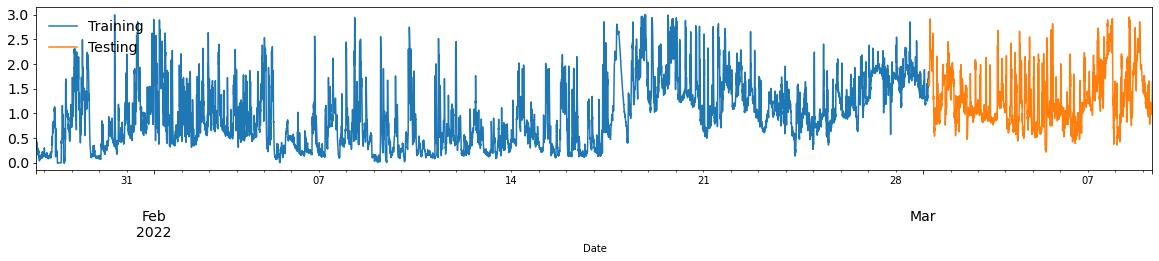

In [8]:
# Plot data
#
fig, ax = plt.subplots( figsize=(20, 3) );

df_train['PM25'].plot(ax=ax);
df_test['PM25'].plot(ax=ax);

plt.legend(['Training', 'Testing'], fontsize=14, frameon=False);
plt.xticks(size=14);
plt.yticks(size=14);

# Create TimeSeriesDataSets

In [9]:
config = {'max_encoder_length'   :  12,
          'min_prediction_length':   6,
          'max_prediction_length':   6,
          'batch size'           :  32,
          'n_workers'            :   0,
          'seed'                 :  42,}
    
    
training_cutoff_idx = df_train.time_idx.max() - 100 # CFG.max_prediction_length

## TimeSeriesDataSet: Training

In [10]:
train_ds = TimeSeriesDataSet(
    df_train[lambda x: x.time_idx <= training_cutoff_idx],
    #
    time_idx  = 'time_idx',
    target    = 'PM25',
    group_ids = ['const'],  
    max_encoder_length    = config['max_encoder_length'],
    max_prediction_length = config['max_prediction_length'],
    min_prediction_length = config['min_prediction_length'],
    #
    #
    # Selected Variables
    static_categoricals               = [],  
    static_reals                      = [],
    time_varying_known_categoricals   = ['Minute', 'Hour'],
    time_varying_known_reals          = [],
    time_varying_unknown_categoricals = [],
    time_varying_unknown_reals        = ['PM25', 'PM25_6_mean', 'PM25_12_mean'],
    #
    predict_mode   = False,
    target_normalizer= TorchNormalizer(method='standard'),        
#     categorical_encoders={
#         '__group_id__const': NaNLabelEncoder(add_nan=True),
#         'Day': NaNLabelEncoder(add_nan=True),
#         'Month': NaNLabelEncoder(add_nan=True),
#     }, 
    scalers={
        'usage'     : TorchNormalizer(method='standard'),
        'time_idx'  : TorchNormalizer(method='standard'),
        #
        'PM25_6_mean'  : TorchNormalizer(method='standard'),
        'PM25_12_mean' : TorchNormalizer(method='standard'),
#         'Minute'    : TorchNormalizer(method='standard'),
#         'Hour'      : TorchNormalizer(method='standard'),
    }
)


train_ds.get_parameters()

{'time_idx': 'time_idx',
 'target': 'PM25',
 'group_ids': ['const'],
 'weight': None,
 'max_encoder_length': 12,
 'min_encoder_length': 12,
 'min_prediction_idx': 11,
 'min_prediction_length': 6,
 'max_prediction_length': 6,
 'static_categoricals': [],
 'static_reals': [],
 'time_varying_known_categoricals': ['Minute', 'Hour'],
 'time_varying_known_reals': [],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['PM25', 'PM25_6_mean', 'PM25_12_mean'],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': False,
 'lags': {},
 'add_relative_time_idx': False,
 'add_target_scales': False,
 'add_encoder_length': False,
 'target_normalizer': TorchNormalizer(),
 'categorical_encoders': {'__group_id__const': NaNLabelEncoder(),
  'Minute': NaNLabelEncoder(),
  'Hour': NaNLabelEncoder()},
 'scalers': {'usage': TorchNormalizer(),
  'time_idx': TorchNormalizer(),
  'PM25_6_mean': TorchNormalizer(),
  'PM25_12_mean': TorchNormalizer()},
 'randomize_

## TimeSeriesDataSet: Validation

In [11]:
# create validation set (predict=True)
#
valid_ds = TimeSeriesDataSet.from_dataset(dataset            = train_ds, 
                                          data               = df_train, #[lambda x: x.time_idx > training_cutoff_idx],
                                          predict            = True, 
                                          stop_randomization = True,
                                          )

## Data Loaders

In [12]:
train_dataloader = train_ds.to_dataloader(train       = True,  
                                          batch_size  = config['batch size'], 
                                          num_workers = config['n_workers']) 

valid_dataloader = valid_ds.to_dataloader(train       = False, 
                                          batch_size  = config['batch size'], 
                                          num_workers = config['n_workers']) 

### Training parameters

In [13]:
parameters = dict(
    epochs           = 100,
    hidden_size      = 128,
    att_head_size    = 4,      # number of attention heads. Set to up to 4 for large datasets
    hidden_cont_size = 48,     #8   # set to <= hidden_size
    dp               = 0.3,
    lstm_layers      = 1,      #1
)
    

## Calculate suggested learning rate

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 288   
3  | prescalers                         | ModuleDict                      | 288   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 56.3 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 66.3 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 66.3 K
9  | 

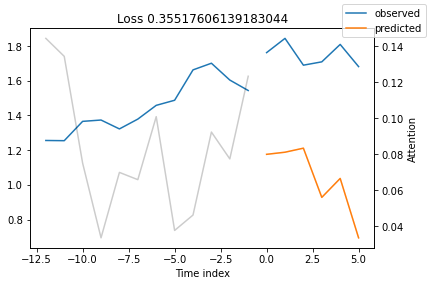

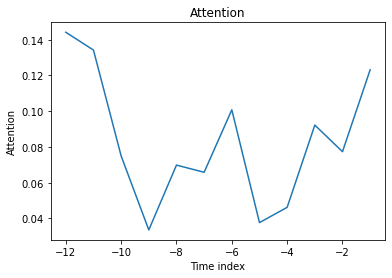

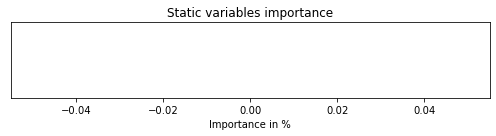

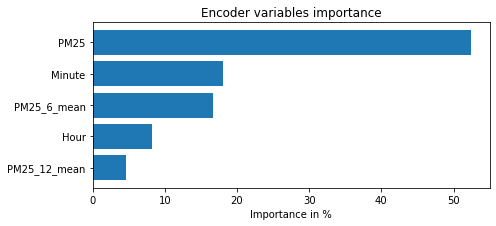

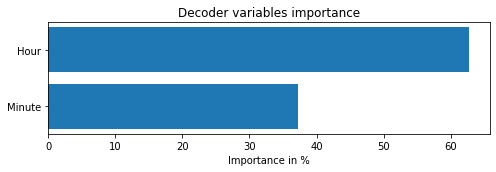

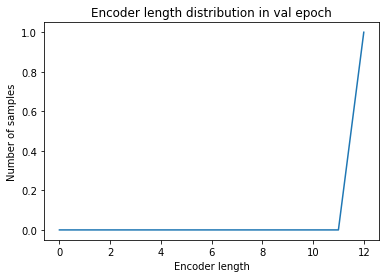

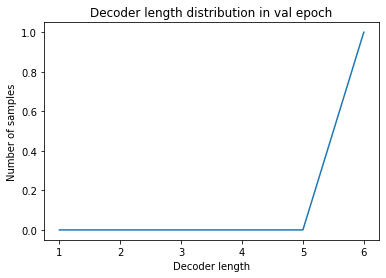

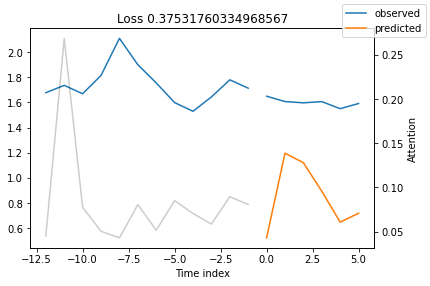

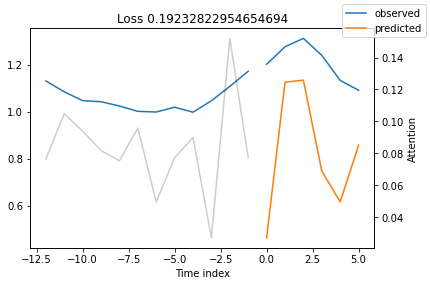

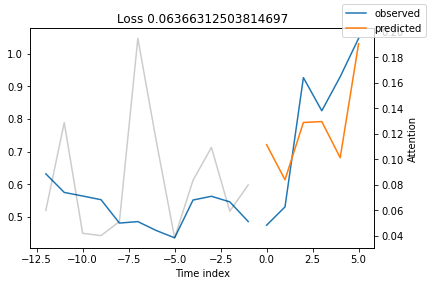

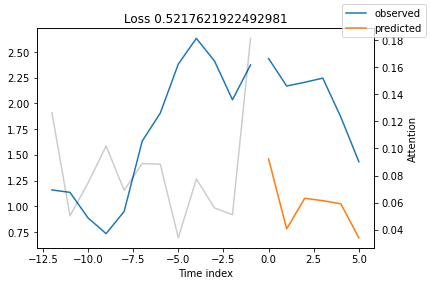

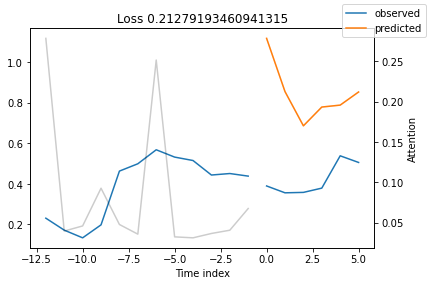

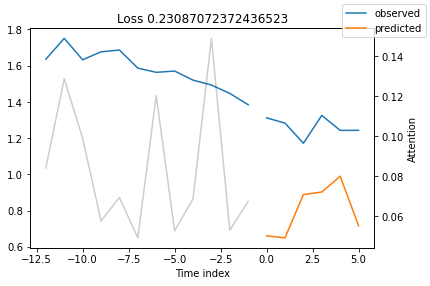

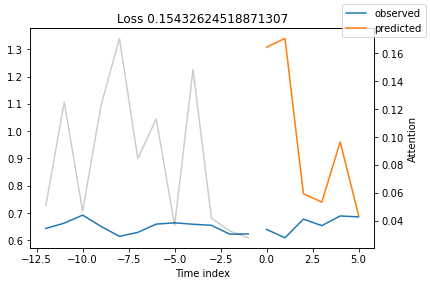

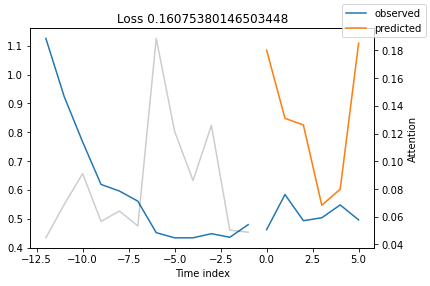

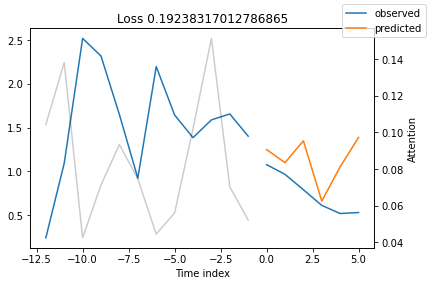

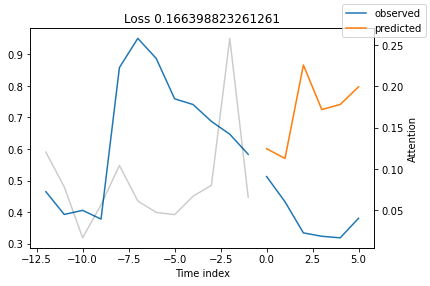

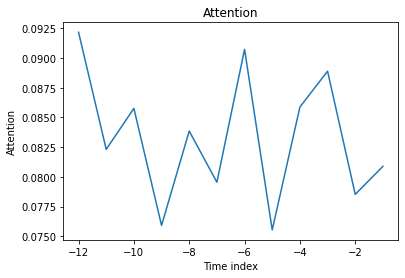

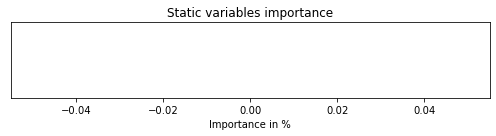

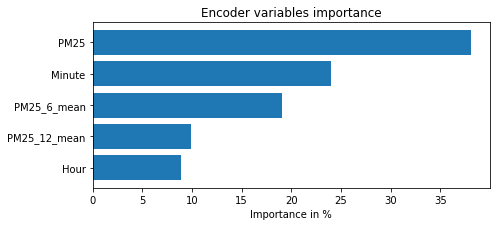

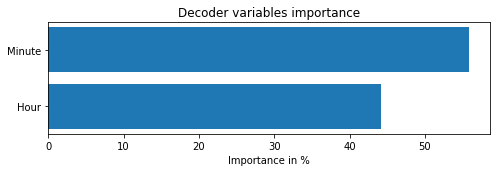

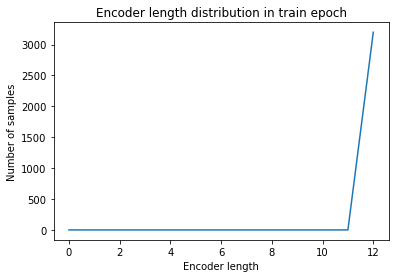

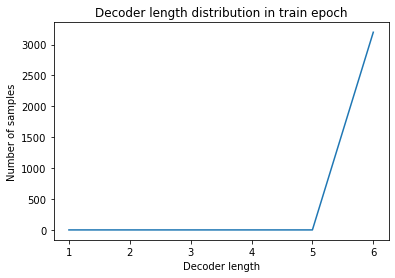

In [14]:
# Set Loss function
#
Loss = QuantileLoss([0.5]) # SMAPE, PoissonLoss, QuantileLoss

model = TemporalFusionTransformer.from_dataset(
    train_ds,
    lstm_layers            = parameters['lstm_layers'],   #2 
    hidden_size            = parameters['hidden_size'],
    hidden_continuous_size = parameters['hidden_cont_size'],
    attention_head_size    = parameters['att_head_size'],
    dropout                = parameters['dp'],
    loss                   = Loss,
    #
    learning_rate              = 0.01, #params['LR'],  # 1e-3,
    log_interval               = 10, # steps ?
    reduce_on_plateau_patience = 5,
#     logging_metrics            = nn.ModuleList([SMAPE(), MAE(), RMSE(), MAPE()])
)


trainer = pl.Trainer(
    gpus              = None,  #  0, 1, None
    gradient_clip_val = 0.1,
)

res = trainer.tuner.lr_find(model            = model,
                            train_dataloader = train_dataloader,
                            val_dataloaders  = valid_dataloader,
                            max_lr           = 1e-3,
                            min_lr           = 1e-6)

### Suggested learning rate

[INFO] Suggested learning rate: 2.290867652767773e-06


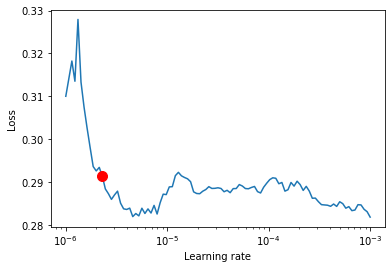

In [15]:
print('[INFO] Suggested learning rate:', res.suggestion())

fig = res.plot(show    = True, 
               suggest = True)
fig.show()

# Setup TFT model

In [16]:
# Set Loss function
#
Loss = QuantileLoss([0.5]) # SMAPE, PoissonLoss, QuantileLoss
Loss = RMSE()

model = TemporalFusionTransformer.from_dataset(
    train_ds,
    lstm_layers            = parameters['lstm_layers'],   #2 
    hidden_size            = parameters['hidden_size'],
    hidden_continuous_size = parameters['hidden_cont_size'],
    attention_head_size    = parameters['att_head_size'],
    dropout                = parameters['dp'],
    loss                   = Loss,
    #
    learning_rate              = res.suggestion(),
    log_interval               = 20, # steps ?
    reduce_on_plateau_patience = 30,
    logging_metrics            = nn.ModuleList([SMAPE(), MAE(), RMSE(), MAPE()])
)



In [17]:
EarlyStop = EarlyStopping(monitor   = "val_loss", 
                          min_delta = 1e-4, 
                          patience  = 10, 
                          verbose   = False, 
                          mode      = "min")

lr_logger = LearningRateMonitor(logging_interval = 'epoch')  

logger    = TensorBoardLogger("./logs", 
                              name              = 'demo', 
                              default_hp_metric = False) 


trainer = pl.Trainer(
    max_epochs        = parameters['epochs'],
    gpus              = None,
    weights_summary   = "top",
    callbacks         = [lr_logger, EarlyStop],
    logger            = logger,
    gradient_clip_val = 0.1,
    # limit_train_batches=30,  # comment in for training, running valiation every 30 batches
    # fast_dev_run=True,       # comment in to check that networkor dataset has no serious bugs
    # resume_from_checkpoint = './tb_logs/run1/version_1/checkpoints/epoch=29.ckpt'
)

print(f"Number of parameters in network: {model.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 877.3k


In [18]:
# Fit prediction model
#
trainer.fit(model, train_dataloader, valid_dataloader)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 288   
3  | prescalers                         | ModuleDict                      | 288   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 56.3 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 66.3 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 66.3 K
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 66.3

Epoch 0: 100%|██████████| 289/289 [00:28<00:00, 10.05it/s, loss=0.729, v_num=16, val_loss=0.854, train_loss_step=0.662]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|█████████▉| 288/289 [00:29<00:00,  9.91it/s, loss=0.712, v_num=16, val_loss=0.855, train_loss_step=0.689, train_loss_epoch=0.721]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█████████▉| 288/289 [00:28<00:00, 10.04it/s, loss=0.694, v_num=16, val_loss=0.852, train_loss_step=0.655, train_loss_epoch=0.710]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█████████▉| 288/289 [00:29<00:00,  9.78it/s, loss=0.682, v_num=16, val_loss=0.840, train_loss_step=0.746, train_loss_epoch=0.695]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|█████████▉| 288/289 [00:32<00:00,  8.91it/s, loss=0.667, v_num=16, val_loss=0.807, train_loss_step=0.664, train_loss_epoch=0.678]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|█████████▉| 288/289 [00:30<00:00,  9.59it/s, loss=0.631, v_num=16, val_loss=0.766, train_loss_step=0.712, train_loss_epoch=0.659]
Valid

Epoch 22: 100%|█████████▉| 288/289 [00:33<00:00,  8.55it/s, loss=0.47, v_num=16, val_loss=0.155, train_loss_step=0.383, train_loss_epoch=0.468] 
Validating: 0it [00:00, ?it/s]
Epoch 23: 100%|█████████▉| 288/289 [00:35<00:00,  8.19it/s, loss=0.467, v_num=16, val_loss=0.156, train_loss_step=0.397, train_loss_epoch=0.468]
Validating: 0it [00:00, ?it/s]
Epoch 24: 100%|█████████▉| 288/289 [00:33<00:00,  8.56it/s, loss=0.44, v_num=16, val_loss=0.157, train_loss_step=0.427, train_loss_epoch=0.467] 
Validating: 0it [00:00, ?it/s]
Epoch 25: 100%|█████████▉| 288/289 [00:33<00:00,  8.51it/s, loss=0.464, v_num=16, val_loss=0.158, train_loss_step=0.592, train_loss_epoch=0.465]
Validating: 0it [00:00, ?it/s]
Epoch 26: 100%|█████████▉| 288/289 [00:34<00:00,  8.43it/s, loss=0.476, v_num=16, val_loss=0.158, train_loss_step=0.486, train_loss_epoch=0.462]
Validating: 0it [00:00, ?it/s]
Epoch 27: 100%|█████████▉| 288/289 [00:33<00:00,  8.50it/s, loss=0.45, v_num=16, val_loss=0.159, train_loss_step=0.471, 

## Load model and predict

In [19]:
## load best model from checkpoint

best_model_path = trainer.checkpoint_callback.best_model_path
best_model      = TemporalFusionTransformer.load_from_checkpoint( best_model_path )

print('[INFO] Best model loaded from checkpoint: ', best_model_path, 'enc len:', config['max_encoder_length'])
print('[INFO] Best model score:                  ', trainer.checkpoint_callback.best_model_score)

[INFO] Best model loaded from checkpoint:  ./logs/demo/version_16/checkpoints/epoch=20-step=6047.ckpt enc len: 12
[INFO] Best model score:                   tensor(0.1538)


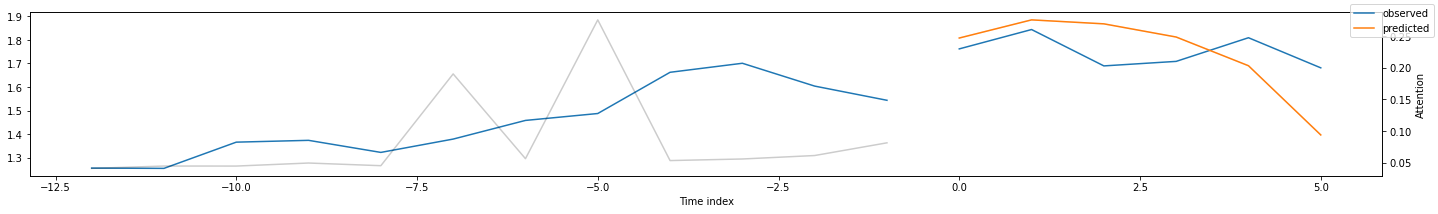

In [20]:
y_pred, new_x = best_model.predict(valid_ds, batch_size=32, mode= 'raw', return_x = True,) # return_index=True

fig, ax = plt.subplots( figsize=(20, 3) )
best_model.plot_prediction(new_x, y_pred, idx=0, show_future_observed=True, ax=ax);

# Interpret model 

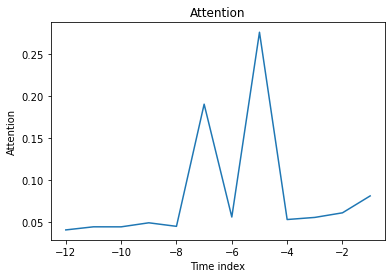

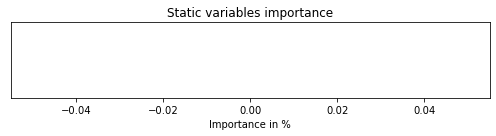

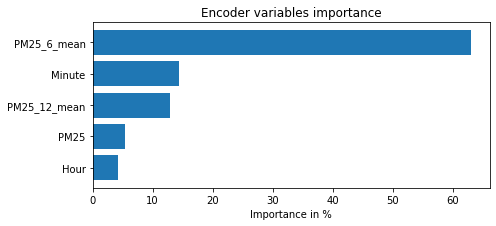

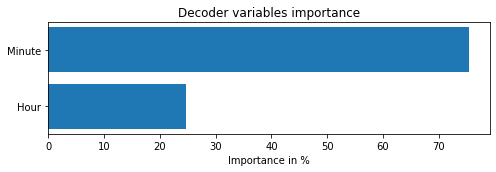

In [21]:
# get model interpr for current preds
interpretation = best_model.interpret_output(y_pred, reduction="sum");

# plot results
best_model.plot_interpretation( interpretation,  );

# Evaluation

In [22]:
Real, Predictions = [], []
for i in range(config['max_prediction_length'], df_test.shape[0], config['max_prediction_length']):
    testY = pd.concat( [df_train[-100:], df_test[:i]] ) 
    
    # create validation set (predict=True)
    #
    valid_ds = TimeSeriesDataSet.from_dataset(dataset            = train_ds, 
                                              data               = testY,
                                              predict            = True, 
                                              stop_randomization = True
                                             )


    y_pred, new_x = best_model.predict(valid_ds, 
                                       batch_size = 32, 
                                       mode       = 'raw', 
                                       return_x   = True) # return_index=True)                                          )


    Real        += [ testY[-6:]['PM25'].tolist() ];
    Predictions += y_pred['prediction'][:,:].tolist();
 

# Convert to ndarrays
#
Real        = np.asarray( Real        )
Predictions = np.asarray( Predictions )

In [23]:
# Inverse transformation
#
Real        = np.exp( Real )        - 1
Predictions = np.exp( Predictions ) - 1

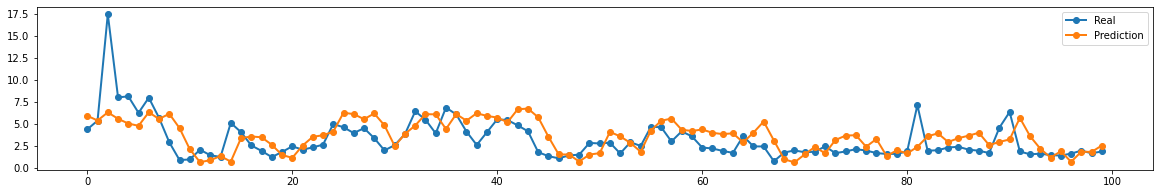

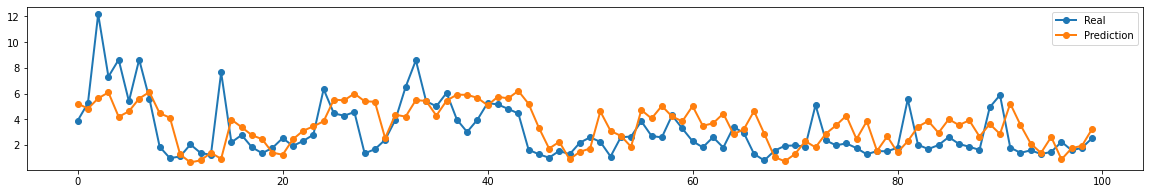

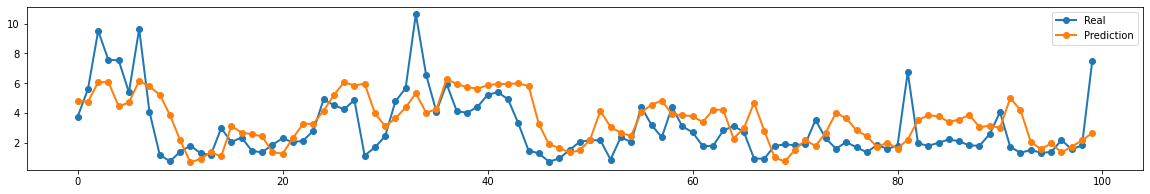

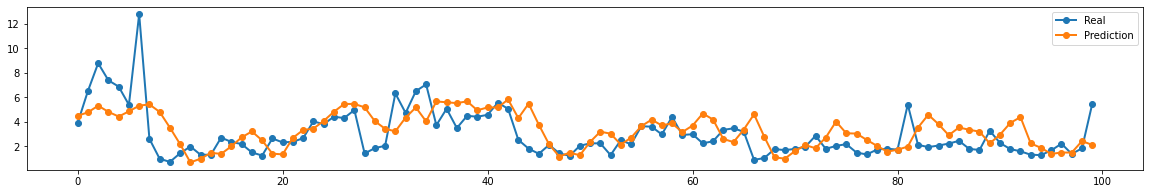

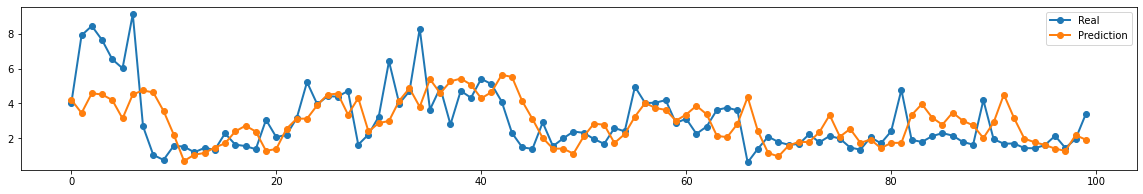

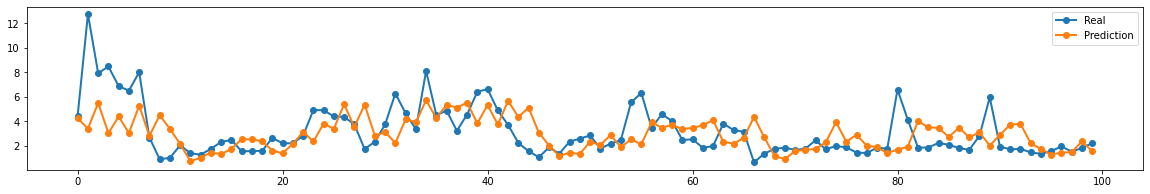

In [24]:
from utils.PerformanceMetrics import * 


Performance = {'Horizon': [], 'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}


for i in range( config['max_prediction_length'] ):
    
    Prices = pd.DataFrame([])
    Prices['Real']       = Real[:,i]
    Prices['Prediction'] = Predictions[:,i]
    
    Prices[:100].plot( figsize=(20, 3), marker = 'o', linewidth = 2 )
    plt.show()
    
    
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    
    # Store results (Performance metrics)
    #
    Performance['Horizon'] += [ i+1 ]
    #
    Performance['RMSE']    += [ RMSE  ]
    Performance['MAE']     += [ MAE   ]
    Performance['SMAPE']   += [ SMAPE ]
    Performance['R2']      += [ R2    ]
    
    
Performance = pd.DataFrame( Performance )
Performance.set_index('Horizon', inplace=True)    

In [25]:
Performance

,RMSE,MAE,SMAPE,R2
Horizon,,,,
1,2.536221,1.764724,55.174366,0.184802
2,2.700390,1.913650,58.443572,0.139958
3,2.686657,1.921400,57.866410,0.160992
4,2.667265,1.863801,56.961041,0.163417
5,2.677736,1.755378,54.112623,0.133228
6,2.823095,1.844524,55.245924,0.043438


In [26]:
# PM2.5, Loss = RMSE
# 	RMSE	MAE	SMAPE	R2
# Horizon				
# 1	2.288396	1.597721	48.151801	0.336332
# 2	2.381520	1.654942	50.375768	0.331079
# 3	2.431159	1.625406	49.519783	0.312981
# 4	2.518536	1.682234	51.543788	0.254113
# 5	2.439006	1.596851	50.398382	0.280891
# 6	2.595853	1.697636	52.985287	0.191235


## Examples

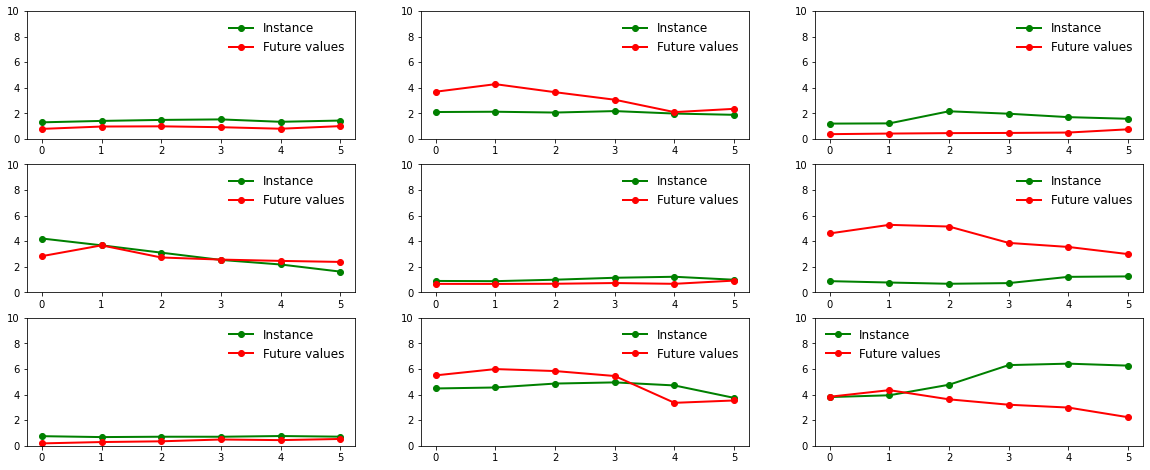

In [30]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (20, 8) )
RandomInstances = [113, 75, 141, 325, 139, 185, 188, 27, 31]

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    #
    plt.plot(range( config['max_prediction_length'] ), Real[i],         color='g', marker = 'o', linewidth = 2)
    plt.plot(range( config['max_prediction_length'] ), Predictions[i],  color='r', marker = 'o', linewidth = 2)

    plt.legend(['Instance', 'Future values', 'Prediction'], frameon = False, fontsize = 12)
plt.show()

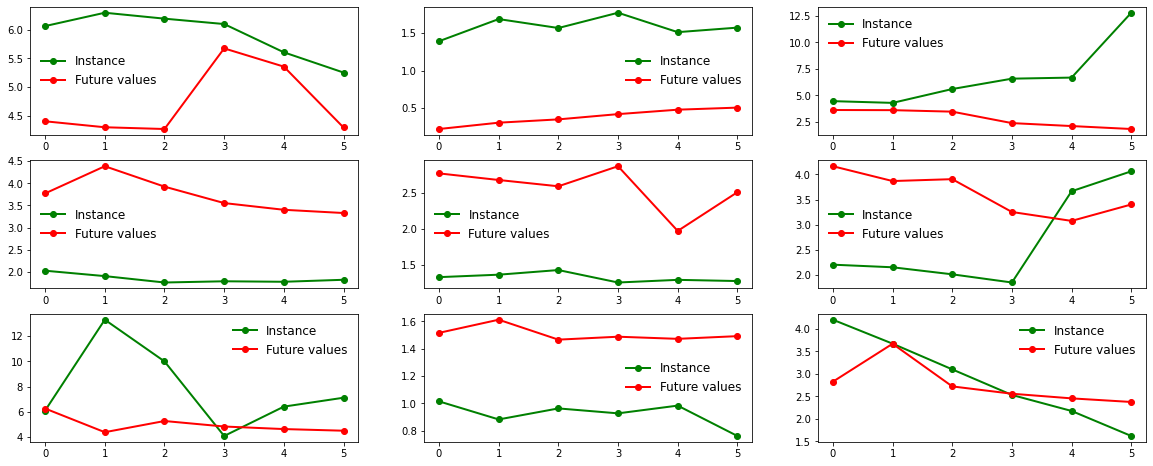

In [31]:
import random

subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (20, 8) )
RandomInstances = [random.randint(1, Predictions.shape[0]) for i in range(0, 9)]

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    #
    plt.plot(range( config['max_prediction_length'] ), Real[i],         color='g', marker = 'o', linewidth = 2)
    plt.plot(range( config['max_prediction_length'] ), Predictions[i],  color='r', marker = 'o', linewidth = 2)

    plt.legend(['Instance', 'Future values', 'Prediction'], frameon = False, fontsize = 12)
plt.show()

In [29]:
Outputs = pd.DataFrame([])
#
#
Outputs['PM2.5'] = Real.flatten()
Outputs['TFT']   = Predictions.flatten()
#
Outputs.to_csv('Predictions/TFT.csv')